# Analyze timestamp information in train_date.csv

In this Notebook I looked at:
- The time it takes samples to move to each station from (t=t_start)
- The time delay between different stations
- The variation of this time delay / time over different samples
- Differences between defective and normal samples
- Entry and exit stations of the different products
- Station at which samples spend most time

Key observations:
- Within a station all features for a sample have the same timestamp -> all the measurements at a station are done at the same time
- Four different entry stations cover 99% of the samples:
    - 0:    57%
    - 12:    20%
    - 24:    15%
    - 25:    7%
- Exit stations:
    - 37: 92%
    - 51: 5%
    - 38: 2%
- Defective samples have a higher chance to have entered via station 24, no difference for exit stations
- On average defective samples take 3 timeunits longer (14 vs 11) to pass all stations
    - Defective samples take 3 timeunits longer at station 26
    - Following stations take 50% longer time for defective samples: 1,  3,  6,  7, 18, 24, 26, 32, 37, 49
    - The following stations start 30% later for defective samples: 1,  3,  6, 17, 32, 35, 43, 49
- Most stations have a higher error rate between timeunit 800 - 1000

Conclusions / follow-up:
- Can we cluster samples based on entry/exit station?
- Replace dateunit per feature by dateunit per station (double check that all timeunits are same per station)
- Feature set: t since t_start
- Feature set: duration at station
- What to with features without timestamp? Would it be useful to have those? Can we estimate them?
- How can we effectively include the higher error rate in our models?
- Other feature ideas?
- Other questions?


In [1]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [2]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [3]:
[num_info, cat_info, date_info] = [func.get_station_info(f) for f in const.TRAIN_FILES]

# Date features refer to numeric/categorical features
date_info['ref_feat_nr'] = date_info['feature_nr'] - 1
date_info.head()

,line,station,feature_nr,name,ref_feat_nr
0,0,0,1,L0_S0_D1,0
1,0,0,3,L0_S0_D3,2
2,0,0,5,L0_S0_D5,4
3,0,0,7,L0_S0_D7,6
4,0,0,9,L0_S0_D9,8


In [4]:
date_data = pd.read_csv(os.path.join(const.BASE_PATH, const.TRAIN_FILES[2] + '.csv'), index_col=0)
date_data = date_data.transpose()
date_data.head(5)

Id,4,6,7,9,11,13,14,16,18,23,...,2367478,2367480,2367484,2367487,2367488,2367490,2367491,2367492,2367493,2367495
L0_S0_D1,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.17,NaN,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61
L0_S0_D3,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.17,NaN,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61
L0_S0_D5,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.17,NaN,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61
L0_S0_D7,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.17,NaN,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61
L0_S0_D9,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,NaN,1239.17,NaN,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61


In [5]:
date_data = date_data.merge(date_info, how='left', left_index=True, right_on='name').drop(['name','ref_feat_nr'], axis=1)
date_data.head()

Id,4,6,7,9,11,13,14,16,18,23,...,2367487,2367488,2367490,2367491,2367492,2367493,2367495,line,station,feature_nr
0,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,1
1,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,3
2,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,5
3,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,7
4,82.24,NaN,1618.7,1149.2,602.64,1331.66,NaN,NaN,517.64,NaN,...,55.44,NaN,1239.9,NaN,1482.18,608.83,937.61,0,0,9


In [6]:
y=func.read_last_column('train_numeric.csv')#[:500000]

In [7]:
y.shape

(1183747, 1)

In [8]:
y.Response.value_counts()

0    1176868
1       6879
Name: Response, dtype: int64

In [9]:
n_1 = y[y.Response==1].index.values
n_0 = y[y.Response==0].index.values

### Analyze per sample

In [10]:
t_station = date_data.groupby(['line','station']).agg('first').reset_index(drop=True)
t_station = t_station.apply(lambda x: x-x.min(0))
t_station.drop('feature_nr', axis=1, inplace=True)

In [11]:
t_station_1 = t_station.iloc[:,n_1]
t_station_0 = t_station.iloc[:,n_0]
print t_station_0.shape
print t_station_1.shape

(52, 1176868)
(52, 6879)


In [12]:
(t_station.max()-t_station.min()).mean()

10.718402479787969

In [13]:
t_station_0.head()

Id,4,6,7,9,11,13,14,16,18,23,...,2367478,2367480,2367484,2367487,2367488,2367490,2367491,2367492,2367493,2367495
0,0.00,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.00,NaN,...,NaN,0.00,NaN,0.0,NaN,0.00,NaN,0.00,0.00,0.00
1,0.00,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.00,NaN,...,NaN,0.00,NaN,0.0,NaN,0.00,NaN,0.00,0.00,0.00
2,0.00,NaN,0.0,0.01,NaN,NaN,NaN,NaN,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,0.00
3,NaN,NaN,NaN,NaN,0.00,0.01,NaN,NaN,NaN,NaN,...,NaN,0.01,NaN,0.0,NaN,NaN,NaN,0.01,0.00,NaN
4,0.02,NaN,NaN,0.02,0.02,0.02,NaN,NaN,0.01,NaN,...,NaN,0.02,NaN,NaN,NaN,0.03,NaN,NaN,0.02,0.03


In [14]:
# 
sad = pd.DataFrame()
sad['min_0'] = t_station_0.min(1)
sad['min_1'] = t_station_1.min(1)
sad['max_0'] = t_station_0.max(1)
sad['max_1'] = t_station_1.max(1)
sad['mean_0'] = t_station_0.mean(1)
sad['mean_1'] = t_station_1.mean(1)
sad['count_0'] = t_station_0.count(1)
sad['count_1'] = t_station_1.count(1)
sad['std_0'] = t_station_0.std(1)
sad['std_1'] = t_station_1.std(1)
sad['rel_count_0'] = sad['count_0'].astype(float) / (sad['count_0'] + sad['count_1'])
sad['rel_count_1'] = sad['count_1'].astype(float) / (sad['count_0'] + sad['count_1'])

# Info on stay at each station
sad['t_mean_0'] = t_station_0.fillna(method='ffill').diff().mean(1)
sad['t_mean_1'] = t_station_1.fillna(method='ffill').diff().mean(1)
sad['t_std_0'] = t_station_0.fillna(method='ffill').diff().std(1)
sad['t_std_1'] = t_station_1.fillna(method='ffill').diff().std(1)

In [15]:
sad

,min_0,min_1,max_0,max_1,mean_0,mean_1,count_0,count_1,std_0,std_1,rel_count_0,rel_count_1,t_mean_0,t_mean_1,t_std_0,t_std_1
0,0.00,0.00,0.00,0.00,0.000000,0.000000,670254,3608,0.000000,0.000000,0.994646,0.005354,NaN,NaN,NaN,NaN
1,0.00,0.00,33.40,6.80,0.001429,0.002912,670298,3606,0.046218,0.113455,0.994649,0.005351,1.429577e-03,0.002910,0.046219,0.113424
2,0.00,0.00,33.40,6.80,0.008608,0.009246,337957,1817,0.150005,0.159945,0.994652,0.005348,3.579116e-03,0.002258,0.096624,0.007720
3,0.00,0.00,9.90,9.03,0.010315,0.014515,332916,1792,0.144086,0.246111,0.994646,0.005354,4.439954e-03,0.006681,0.100523,0.173236
4,0.00,0.01,83.30,6.83,0.037620,0.037522,333495,1800,0.328033,0.236055,0.994632,0.005368,1.389825e-02,0.013587,0.200901,0.121276
5,0.00,0.01,46.01,9.12,0.037108,0.041253,337701,1811,0.275478,0.298274,0.994666,0.005334,1.399448e-02,0.013967,0.172247,0.121277
6,0.00,0.01,37.88,9.13,0.042806,0.057684,337183,1805,0.260443,0.376285,0.994675,0.005325,3.068904e-03,0.005465,0.047247,0.115678
7,0.00,0.01,83.30,9.02,0.044299,0.042399,333893,1805,0.353306,0.273081,0.994623,0.005377,3.138521e-03,0.005175,0.046006,0.150023
8,0.00,0.01,83.31,9.13,0.045858,0.052321,670275,3606,0.310580,0.330244,0.994649,0.005351,2.301544e-03,0.002269,0.009798,0.006845
9,0.01,0.02,83.34,6.84,0.048301,0.047901,224483,1196,0.365843,0.250831,0.994700,0.005300,6.153573e-04,0.000515,0.007640,0.002634


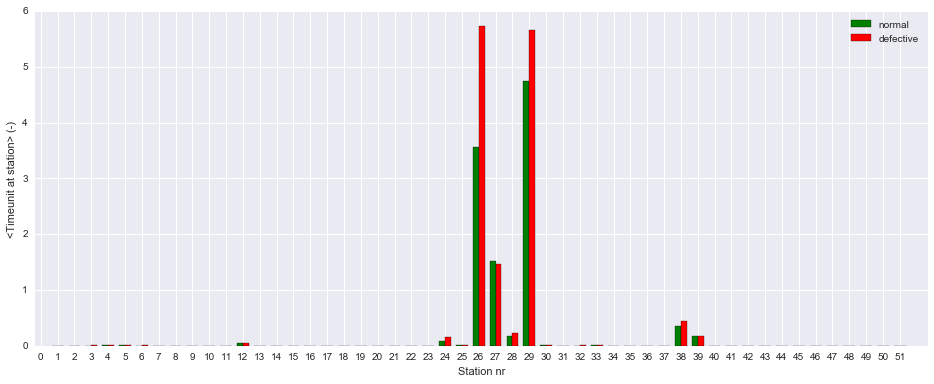

In [16]:
ind = np.arange(sad.shape[0])
width=0.35
fig, ax = plt.subplots(figsize=(16,6))
rects1 = ax.bar(ind, sad['t_mean_0'], width, color='g', label='normal') #, yerr=sad['t_std_0']
rects1 = ax.bar(ind + width, sad['t_mean_1'], width, color='r', label='defective') # , yerr=sad['t_std_1']
ax.legend()
ax.set_xlim([0,53])
#ax.set_ylim([0,1])
ax.set_xticks(ind + width)
ax.set_xticklabels(ind)
ax.set_xlabel('Station nr')
ax.set_ylabel('<Timeunit at station> (-)')

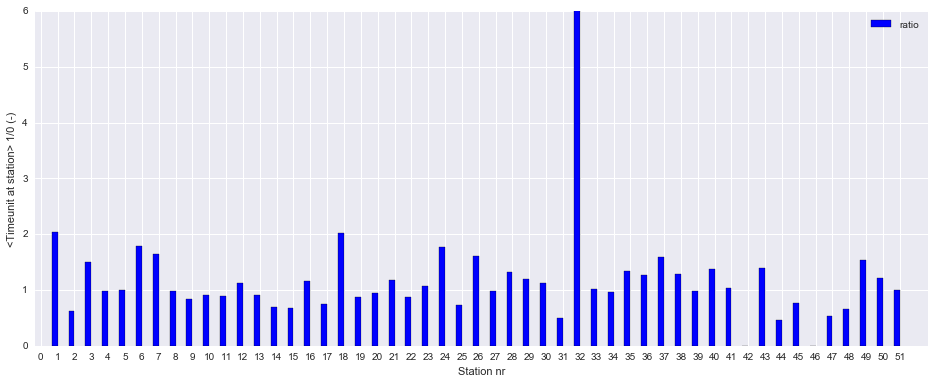

In [17]:
ind = np.arange(sad.shape[0])
width=0.35
fig, ax = plt.subplots(figsize=(16,6))
rects1 = ax.bar(ind, sad['t_mean_1'] / sad['t_mean_0'] , width, color='b', label='ratio') #, yerr=sad['t_std_0']
ax.legend()
ax.set_xlim([0,53])
ax.set_ylim([0,6])
ax.set_xticks(ind + width)
ax.set_xticklabels(ind)
ax.set_xlabel('Station nr')
ax.set_ylabel('<Timeunit at station> 1/0 (-)')

In [79]:
# Stations that take 50% later for defective samples
sad[(sad['t_mean_1'] / sad['t_mean_0'])>1.5].index.values

array([ 1,  3,  6,  7, 18, 24, 26, 32, 37, 49])

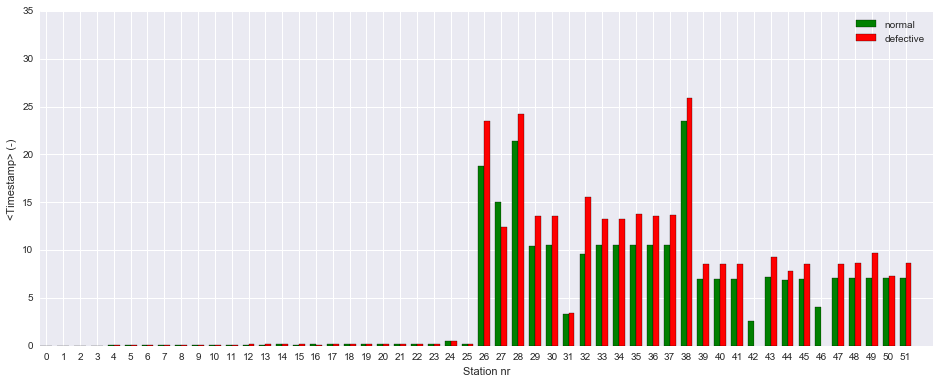

In [18]:
ind = np.arange(sad.shape[0])
width=0.35
fig, ax = plt.subplots(figsize=(16,6))
rects1 = ax.bar(ind, sad['mean_0'], width, color='g', label='normal') #, yerr=sad['std_0']
rects1 = ax.bar(ind + width, sad['mean_1'], width, color='r', label='defective') # , yerr=sad['std_1']
ax.legend()
ax.set_xlim([0,53])
ax.set_ylim([0,35])
ax.set_xticks(ind + width)
ax.set_xticklabels(ind)
ax.set_xlabel('Station nr')
ax.set_ylabel('<Timestamp> (-)')

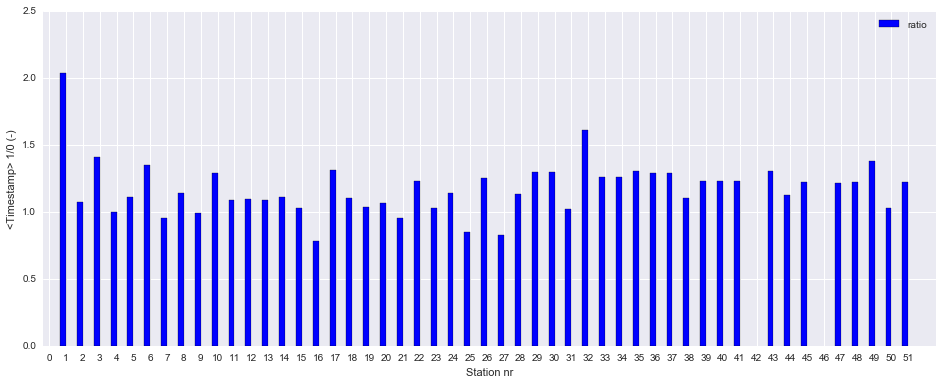

In [19]:
ind = np.arange(sad.shape[0])
width=0.35
fig, ax = plt.subplots(figsize=(16,6))
rects1 = ax.bar(ind, sad['mean_1'] / sad['mean_0'], width, color='b', label='ratio') #, yerr=sad['std_0']
ax.legend()
ax.set_xlim([0,53])
#ax.set_ylim([0,10])
ax.set_xticks(ind + width)
ax.set_xticklabels(ind)
ax.set_xlabel('Station nr')
ax.set_ylabel('<Timestamp> 1/0 (-)')

In [85]:
# Stations that start 30% later for defective samples
sad[(sad['mean_1'] / sad['mean_0'])>1.3].index.values

array([ 1,  3,  6, 17, 32, 35, 43, 49])

### Store data with info per station

In [102]:
filename = 'eda_date_station_aggregation'

sad.to_csv(os.path.join(const.DATA_PATH, filename + '.csv'), index_col='station_nr')

meta = {'script': 'eda_date.ipnb',
        'description': {'min_0': 'minimum timestamp R=0', 
                        'min_1': 'minimum timestamp R=1',
                        'max_0': 'maximum timestamp R=0',
                        'max_1': 'maxium timestamp R=1',
                        'mean_0':'mean timestamp R=0',
                        'mean_1':'mean timestamp R=1',
                        'std_0':'standard deviation timestamp R=0',
                        'std_1':'standard deviation timestamp R=1',
                        'count_0':'number of timestamps R=0',
                        'count_1':'number of timestamp R=1',
                        't_mean_0':'mean time delay R=0',
                        't_mean_1':'mean time delay R=1',
                        't_std_0':'standard deviation time delay R=0',
                        't_std_1':'standard deviation time delay R=1'}
        }

func.write_meta_info(os.path.join(const.DATA_PATH, filename + '.log'), meta)

## Look at some statistics per product
first station
last station


In [20]:
t_station_0.head(20)

Id,4,6,7,9,11,13,14,16,18,23,...,2367478,2367480,2367484,2367487,2367488,2367490,2367491,2367492,2367493,2367495
0,0.00,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,...,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.00
1,0.00,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,...,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.00
2,0.00,NaN,0.00,0.01,NaN,NaN,NaN,NaN,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,0.00
3,NaN,NaN,NaN,NaN,0.00,0.01,NaN,NaN,NaN,NaN,...,NaN,0.01,NaN,0.00,NaN,NaN,NaN,0.01,0.00,NaN
4,0.02,NaN,NaN,0.02,0.02,0.02,NaN,NaN,0.01,NaN,...,NaN,0.02,NaN,NaN,NaN,0.03,NaN,NaN,0.02,0.03
5,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.02,NaN,NaN,NaN,0.02,NaN,NaN
6,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.03,NaN,0.03,NaN,NaN
7,0.02,NaN,NaN,0.02,0.03,0.02,NaN,NaN,0.02,NaN,...,NaN,0.03,NaN,0.03,NaN,NaN,NaN,NaN,0.02,0.03
8,0.03,NaN,0.03,0.02,0.03,0.03,NaN,NaN,0.02,NaN,...,NaN,0.03,NaN,0.03,NaN,0.04,NaN,0.03,0.02,0.04
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.04,NaN,0.03,0.02,NaN


In [21]:
pad = pd.DataFrame()
pad['first_station'] = t_station.apply(lambda x: x.first_valid_index())
pad['last_station'] = t_station.apply(lambda x: x.last_valid_index())
pad['min'] = t_station.min(0)
pad['max'] = t_station.max(0)
pad['count'] = t_station.count(0)

# Info on stay at each station
pad['delta_max'] = t_station.fillna(method='ffill').diff().max(0)
pad['n_max'] = t_station.fillna(method='ffill').diff().idxmax(0)
pad['Response'] = y.Response.values

In [22]:
pad.head()

,first_station,last_station,min,max,count,delta_max,n_max,Response
Id,,,,,,,,
4,0.0,37.0,0.0,5.05,14,4.99,29.0,0
6,12.0,37.0,0.0,2.63,13,2.58,29.0,0
7,0.0,37.0,0.0,5.72,13,5.67,29.0,0
9,0.0,37.0,0.0,4.96,13,4.90,29.0,0
11,0.0,37.0,0.0,3.38,13,3.33,29.0,0


In [23]:
pad.groupby('Response').mean()

,first_station,last_station,min,max,count,delta_max,n_max
Response,,,,,,,
0,7.946443,37.731893,0.0,10.699719,12.152135,9.042926,29.024117
1,9.193544,37.644903,0.0,13.914175,11.731211,11.818328,28.842955


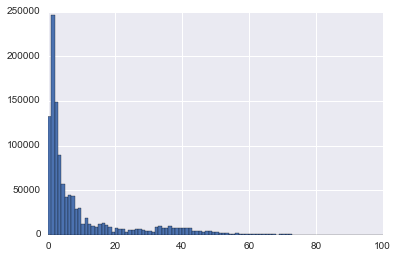

In [26]:
pad['max'].hist(bins=100, range=[0,100])

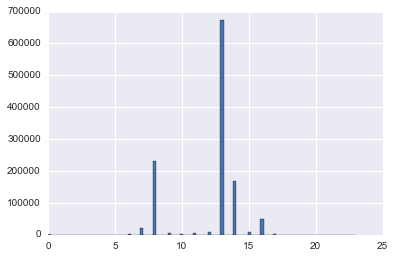

In [27]:
pad['count'].hist(bins=100)

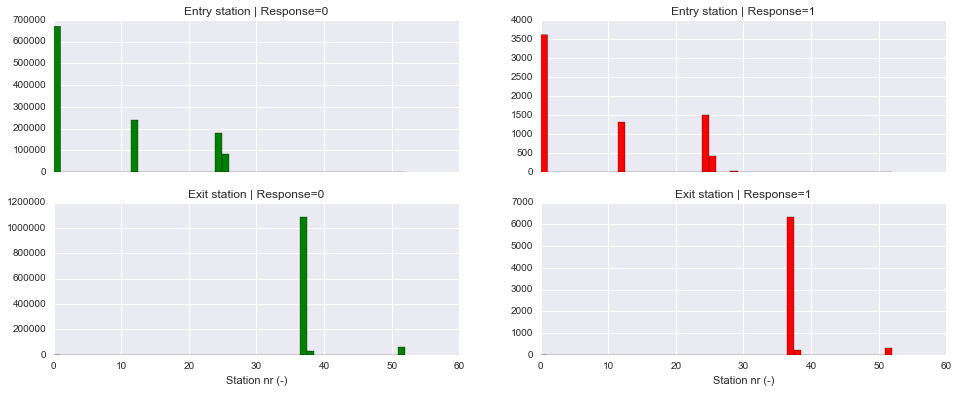

In [28]:
# Look at various entry and exit points
fig, ax = plt.subplots(2,2, sharex=True, figsize=(16,6))
pad[pad.Response==0].first_station.hist(bins=50, color='g', ax=ax[0,0], range=[0,52])
pad[pad.Response==1].first_station.hist(bins=50, color='r', ax=ax[0,1], range=[0,52])
pad[pad.Response==0].last_station.hist(bins=50, color='g', ax=ax[1,0], range=[0,52])
pad[pad.Response==1].last_station.hist(bins=50, color='r', ax=ax[1,1], range=[0,52])
ax[0,0].set_title('Entry station | Response=0')
ax[0,1].set_title('Entry station | Response=1')
ax[1,0].set_title('Exit station | Response=0')
ax[1,1].set_title('Exit station | Response=1')
ax[1,0].set_xlabel('Station nr (-)')
ax[1,1].set_xlabel('Station nr (-)')

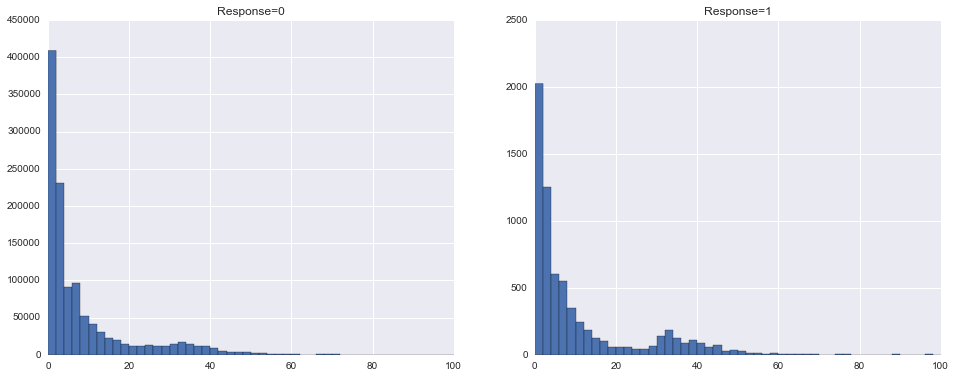

In [29]:
# Biggest time delta between two stations
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(16,6))
pad[pad.Response==0].delta_max.hist(bins=50, ax=ax1, range=[0,100])
ax1.set_title('Response=0')
pad[pad.Response==1].delta_max.hist(bins=50, ax=ax2, range=[0,100])
ax2.set_title('Response=1')

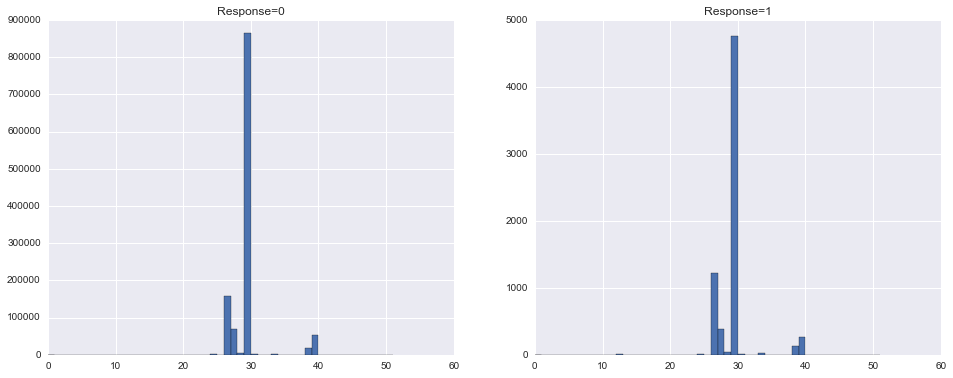

In [30]:
# Location of biggest timestep
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(16,6))
pad[pad.Response==0].n_max.hist(bins=51, ax=ax1, range=[0,51])
ax1.set_title('Response=0')
pad[pad.Response==1].n_max.hist(bins=51, ax=ax2, range=[0,51])
ax2.set_title('Response=1')

### Store data

In [75]:
pad.columns.values

array(['first_station', 'last_station', 'min', 'max', 'count', 'delta_max',
       'n_max', 'Response'], dtype=object)

In [103]:
filename = 'eda_date_sample_aggregation'

pad.to_csv(os.path.join(const.DATA_PATH, filename + '.csv'), index_col='station_nr')

meta = {'script': 'eda_date.ipnb',
        'description': {'first_station': 'number of first station passed', 
                        'last_station': 'number of last station passed',
                        'min': 'minimum timestamp (since t=t_min) (always zero, bug)',
                        'max': 'maxium timestamp (since t=t_min)',
                        'count':'number of stations passed',
                        'delta_max':'maximum time delay between stations',
                        'Response':'response of samples'}
        }

func.write_meta_info(os.path.join(const.DATA_PATH, filename + '.log'), meta)

## Analyze absolute moments in time

In [86]:
time_window = 10
t_station = date_data.groupby(['line','station']).agg('first').reset_index(drop=True)
t_station.drop('feature_nr', axis=1, inplace=True)


In [87]:
t_station = (t_station/time_window).round(0)

In [88]:
t_station.head()

Id,4,6,7,9,11,13,14,16,18,23,...,2367478,2367480,2367484,2367487,2367488,2367490,2367491,2367492,2367493,2367495
0,8.0,NaN,162.0,115.0,60.0,133.0,NaN,NaN,52.0,NaN,...,NaN,124.0,NaN,6.0,NaN,124.0,NaN,148.0,61.0,94.0
1,8.0,NaN,162.0,115.0,60.0,133.0,NaN,NaN,52.0,NaN,...,NaN,124.0,NaN,6.0,NaN,124.0,NaN,148.0,61.0,94.0
2,8.0,NaN,162.0,115.0,NaN,NaN,NaN,NaN,52.0,NaN,...,NaN,NaN,NaN,NaN,NaN,124.0,NaN,NaN,NaN,94.0
3,NaN,NaN,NaN,NaN,60.0,133.0,NaN,NaN,NaN,NaN,...,NaN,124.0,NaN,6.0,NaN,NaN,NaN,148.0,61.0,NaN
4,8.0,NaN,NaN,115.0,60.0,133.0,NaN,NaN,52.0,NaN,...,NaN,124.0,NaN,NaN,NaN,124.0,NaN,NaN,61.0,94.0


In [89]:
t_station_1 = t_station.iloc[:,n_1]
t_station_0 = t_station.iloc[:,n_0]
print t_station_0.shape
print t_station_1.shape

(52, 1176868)
(52, 6879)


In [90]:
t_station_0.head()

Id,4,6,7,9,11,13,14,16,18,23,...,2367478,2367480,2367484,2367487,2367488,2367490,2367491,2367492,2367493,2367495
0,8.0,NaN,162.0,115.0,60.0,133.0,NaN,NaN,52.0,NaN,...,NaN,124.0,NaN,6.0,NaN,124.0,NaN,148.0,61.0,94.0
1,8.0,NaN,162.0,115.0,60.0,133.0,NaN,NaN,52.0,NaN,...,NaN,124.0,NaN,6.0,NaN,124.0,NaN,148.0,61.0,94.0
2,8.0,NaN,162.0,115.0,NaN,NaN,NaN,NaN,52.0,NaN,...,NaN,NaN,NaN,NaN,NaN,124.0,NaN,NaN,NaN,94.0
3,NaN,NaN,NaN,NaN,60.0,133.0,NaN,NaN,NaN,NaN,...,NaN,124.0,NaN,6.0,NaN,NaN,NaN,148.0,61.0,NaN
4,8.0,NaN,NaN,115.0,60.0,133.0,NaN,NaN,52.0,NaN,...,NaN,124.0,NaN,NaN,NaN,124.0,NaN,NaN,61.0,94.0


In [91]:
print('Min: {}'.format(t_station_0.min().min()))
print('Max: {}'.format(t_station_0.max().max()))

Min: 0.0
Max: 172.0


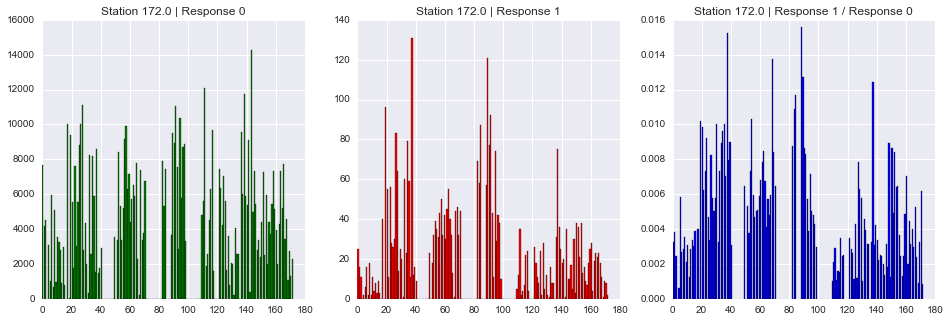

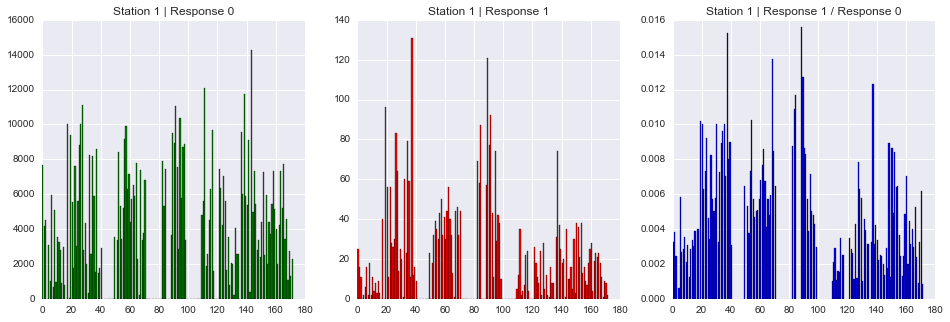

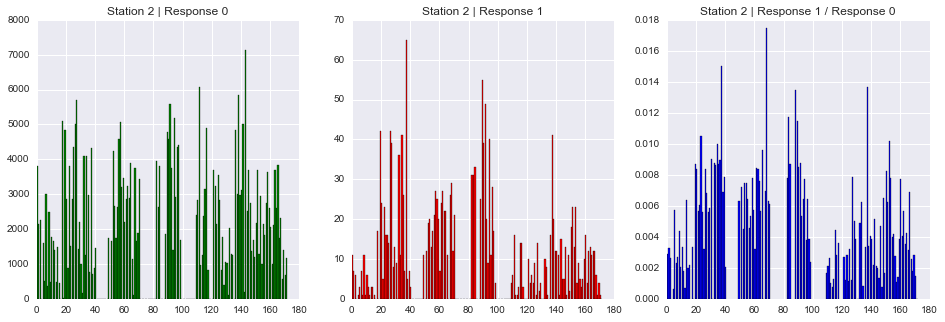

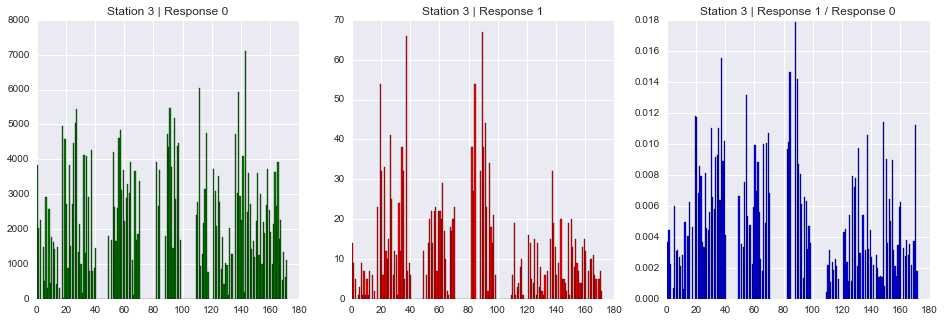

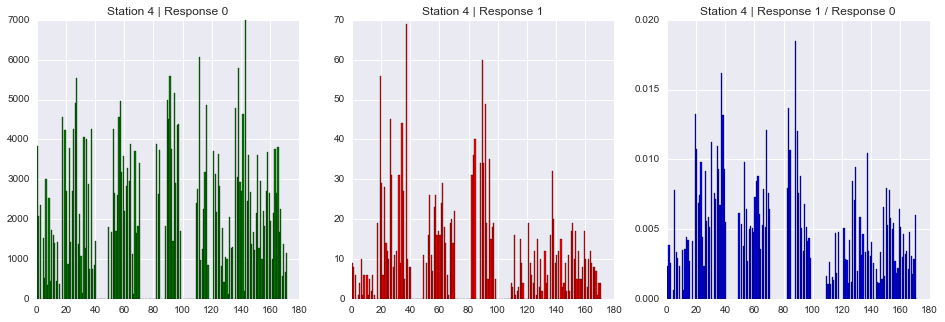

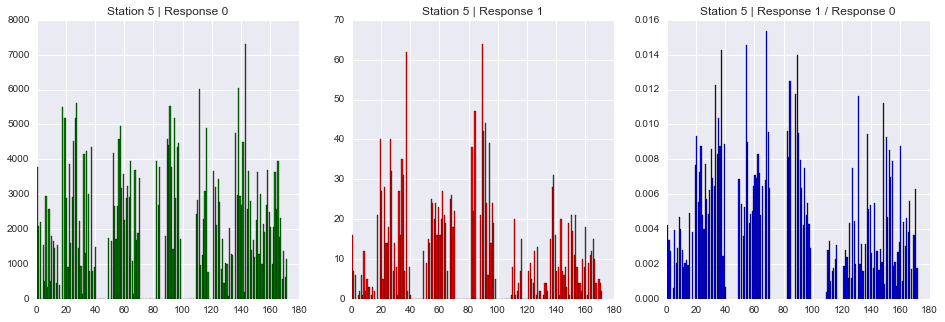

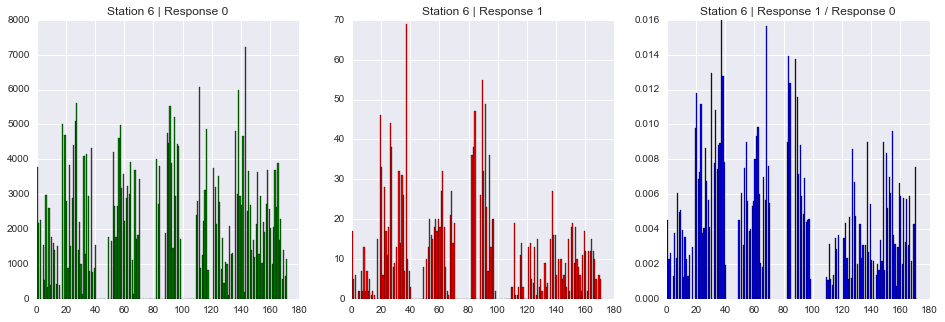

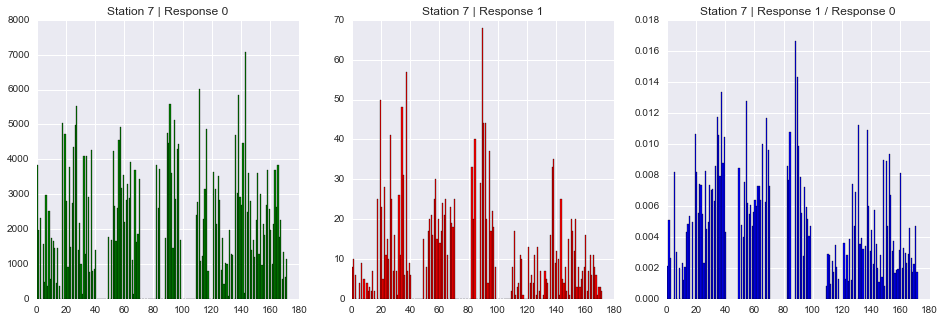

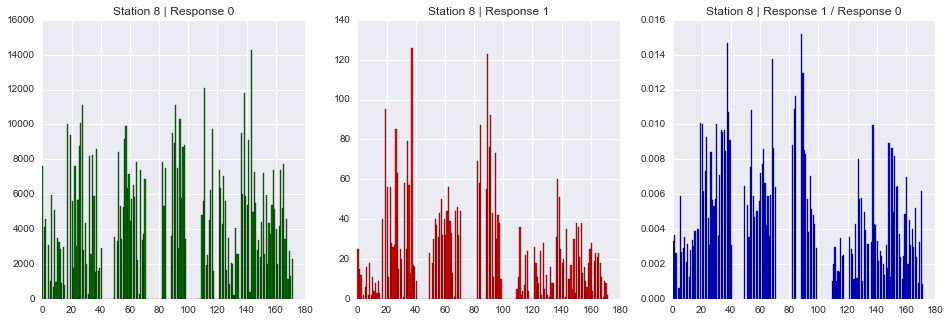

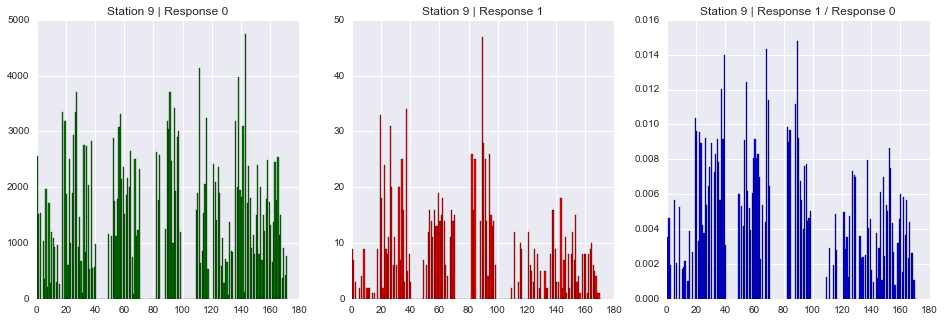

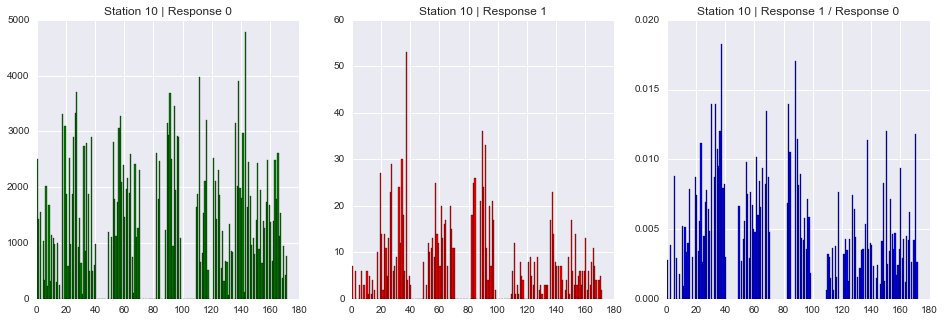

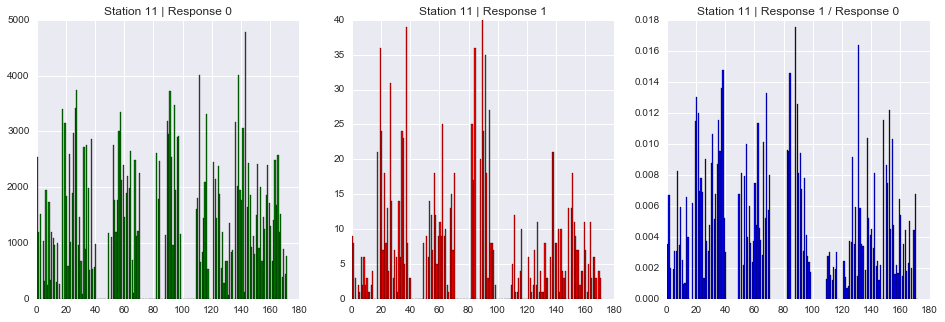

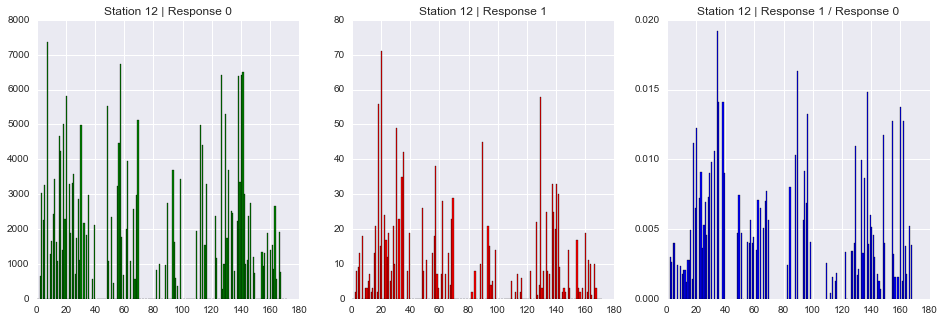

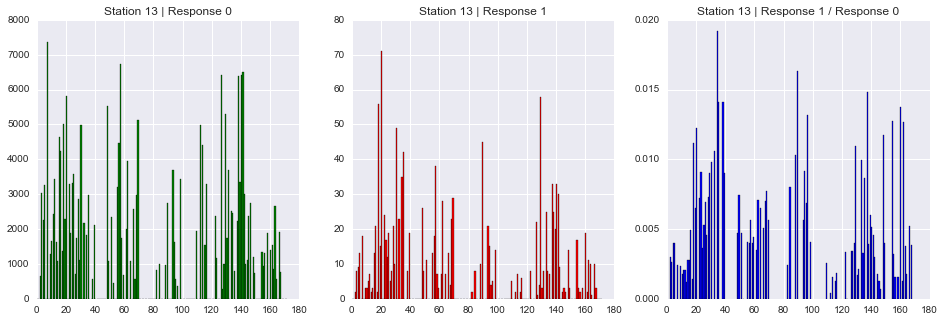

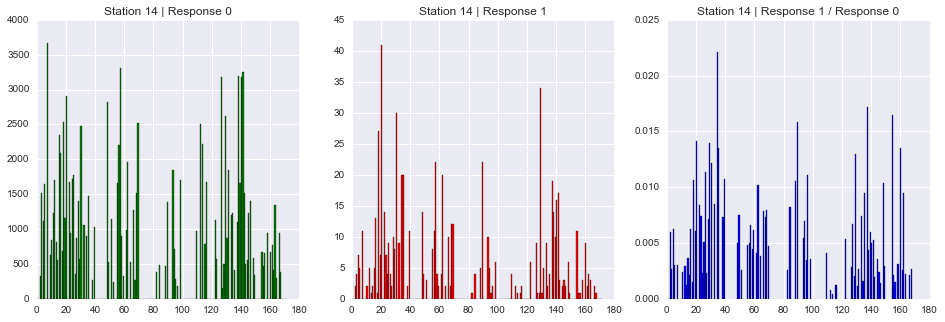

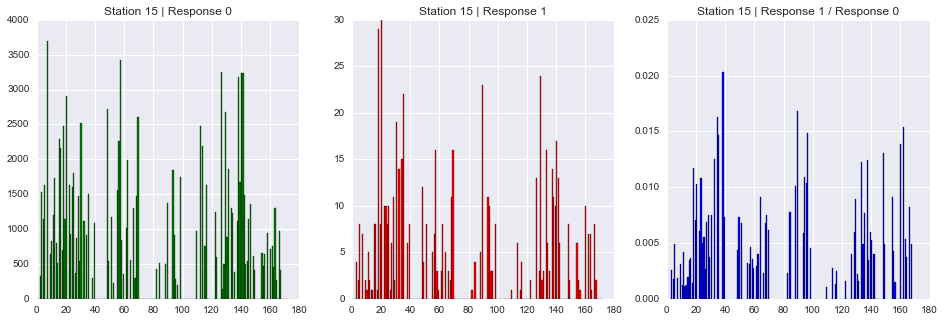

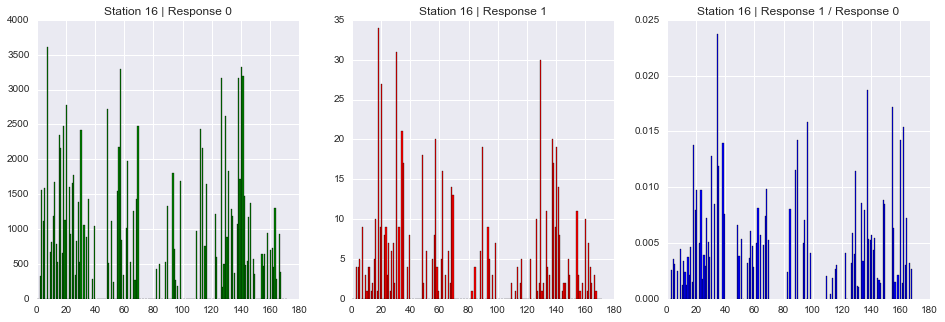

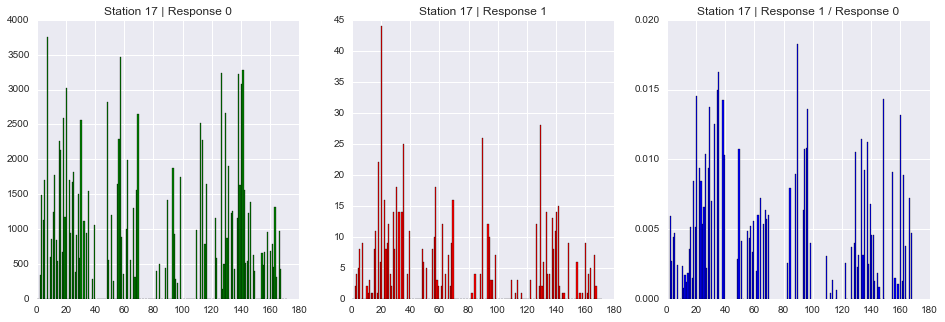

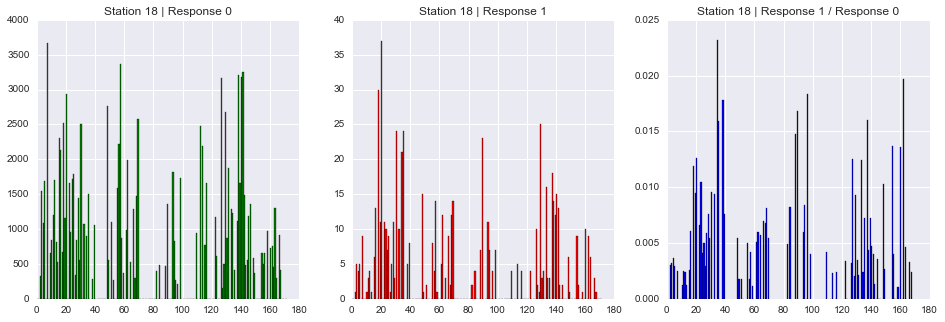

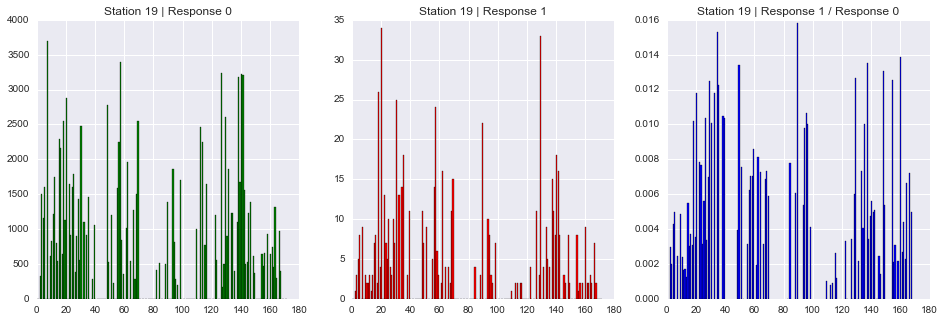

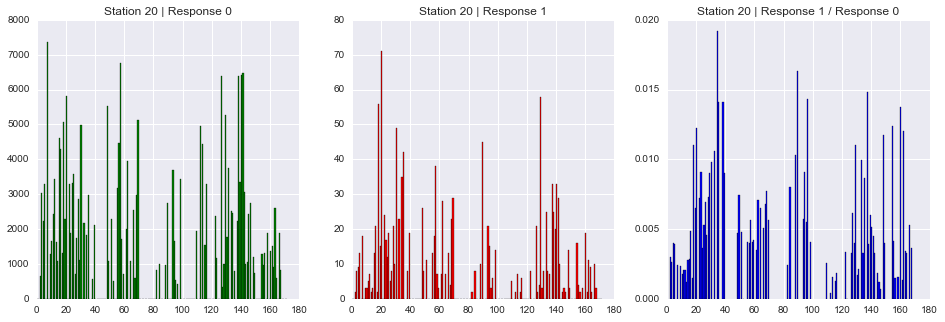

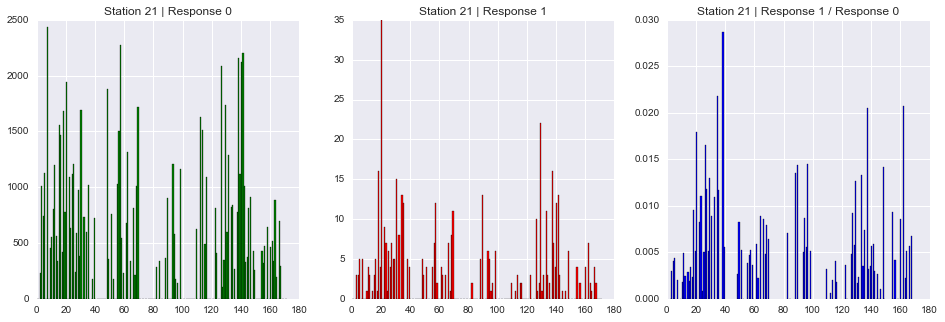

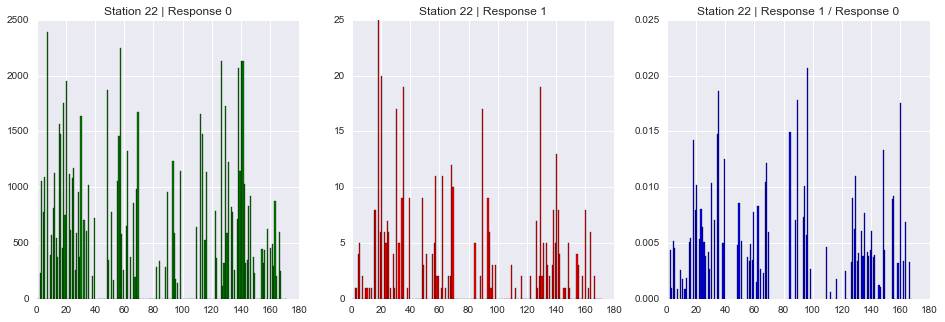

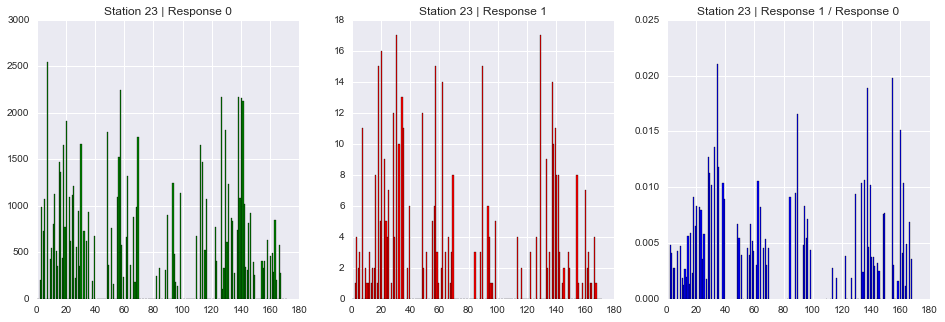

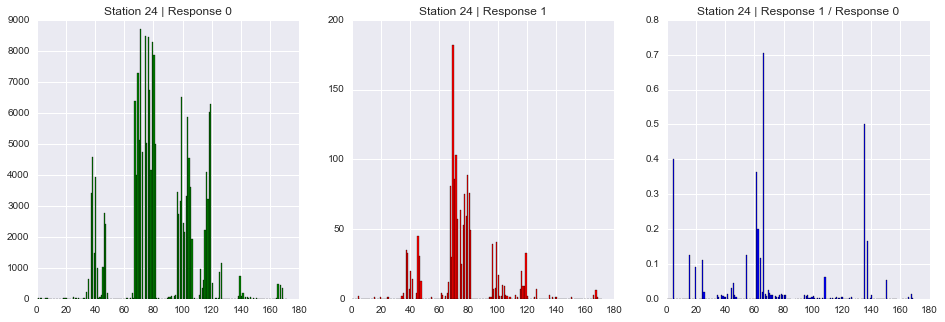

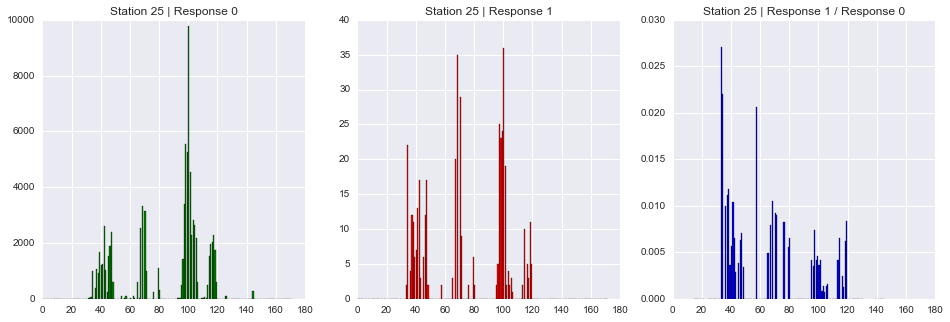

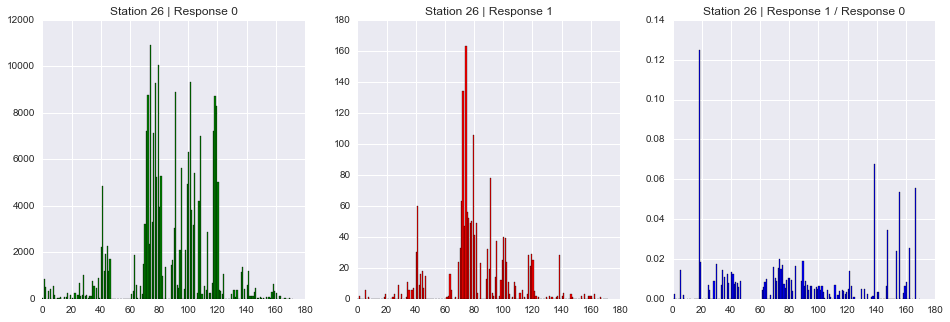

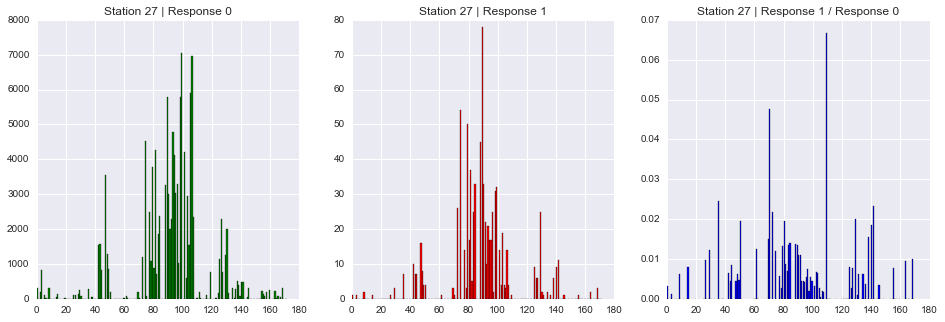

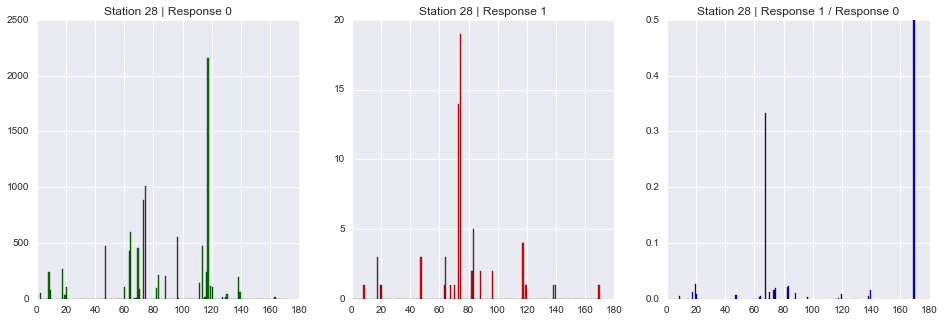

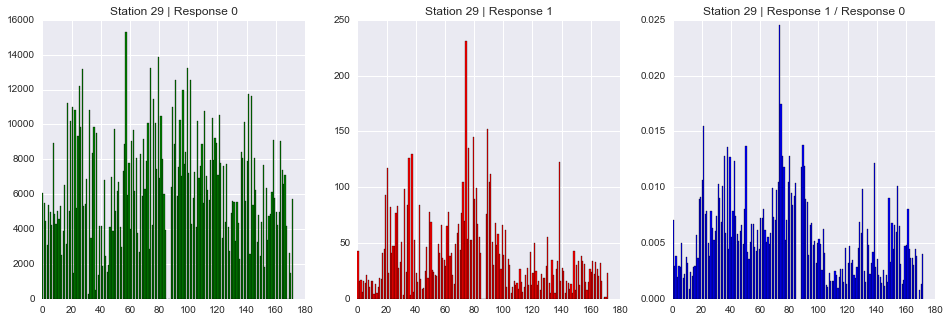

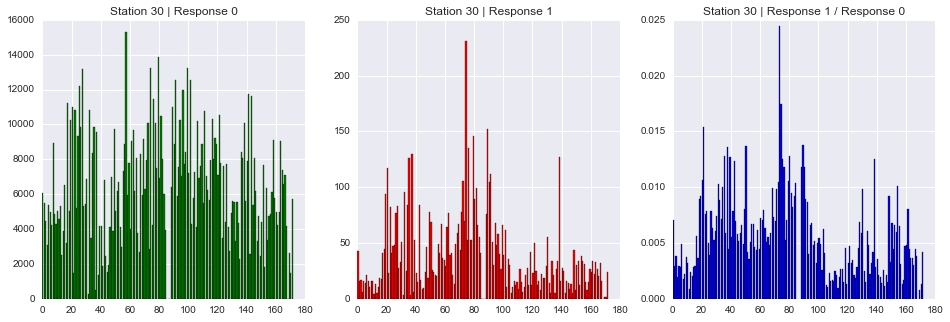

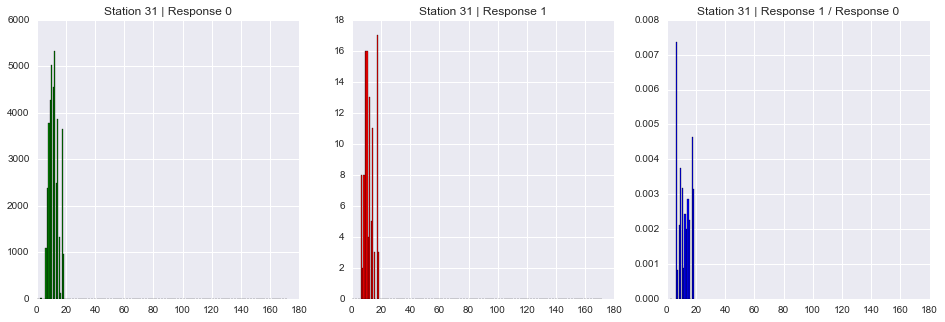

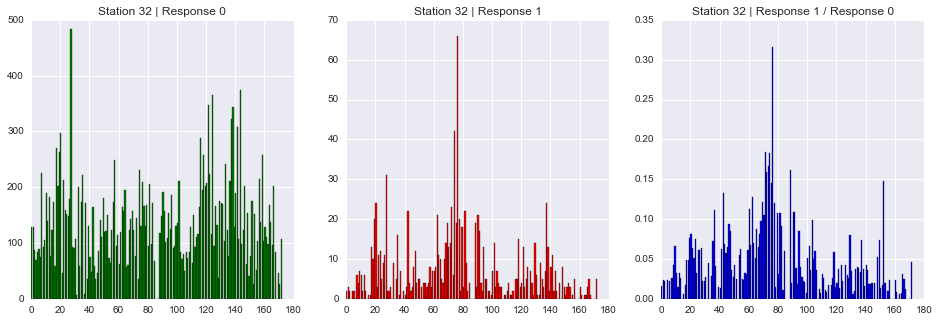

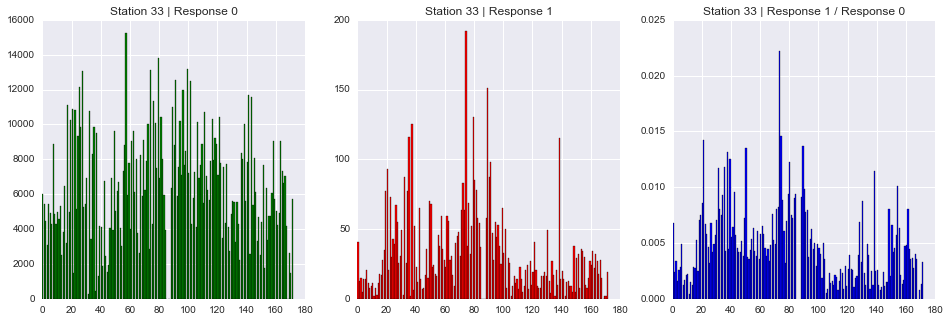

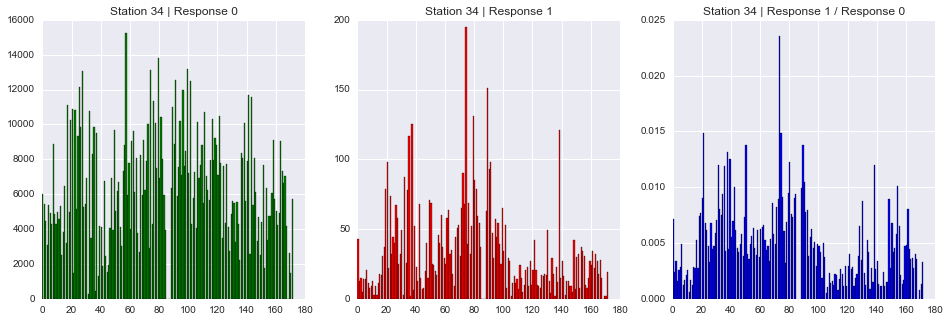

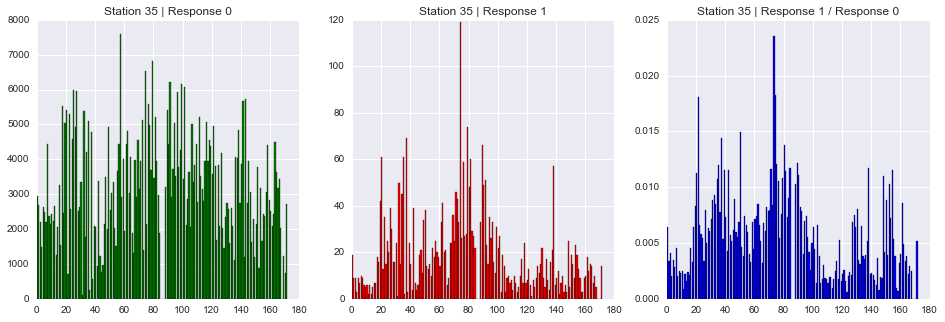

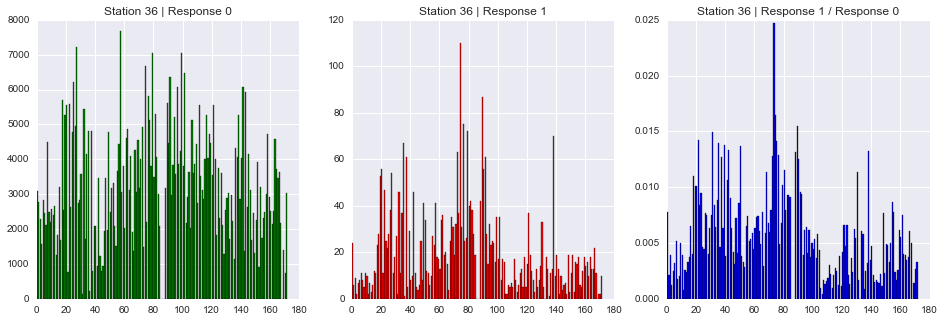

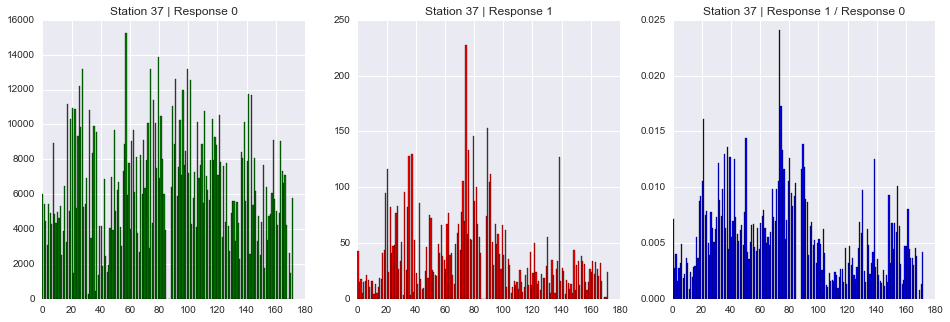

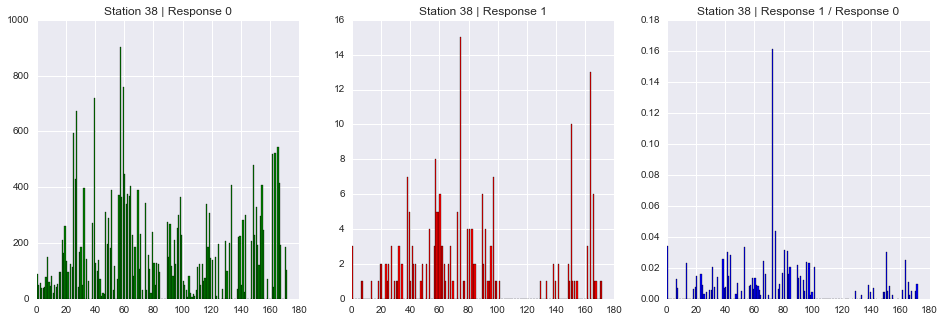

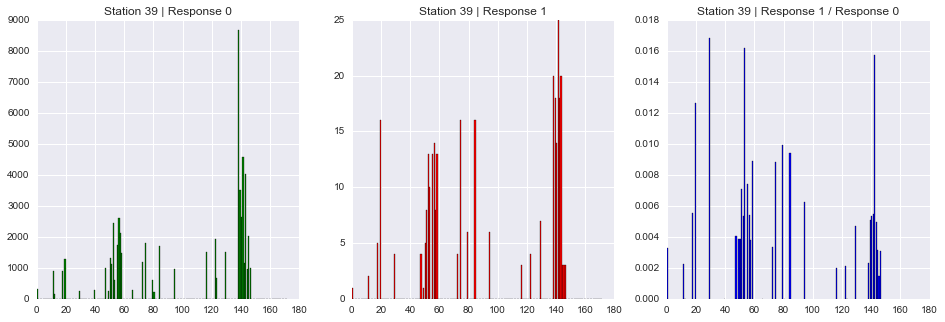

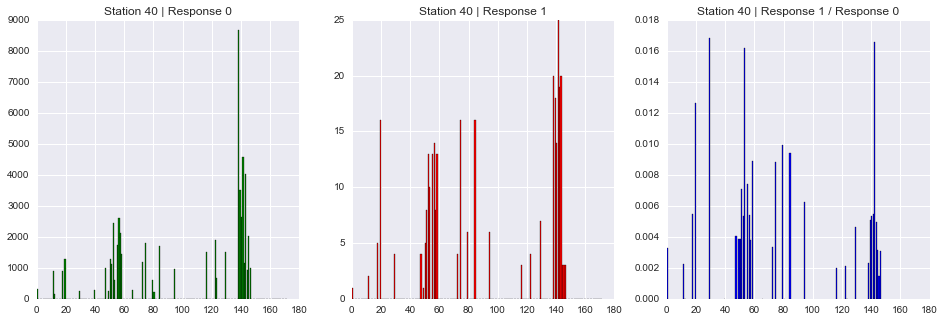

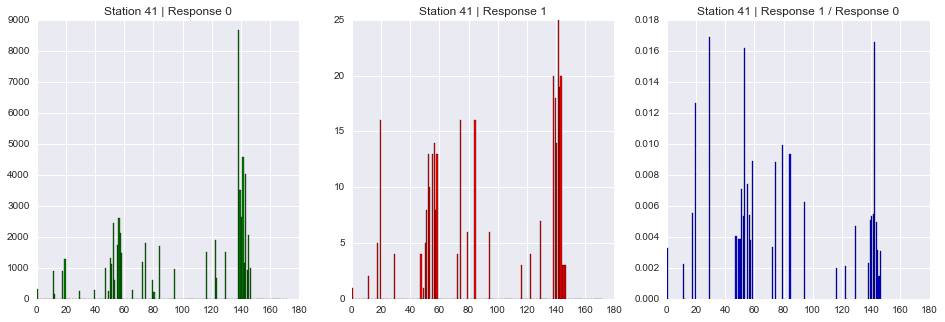

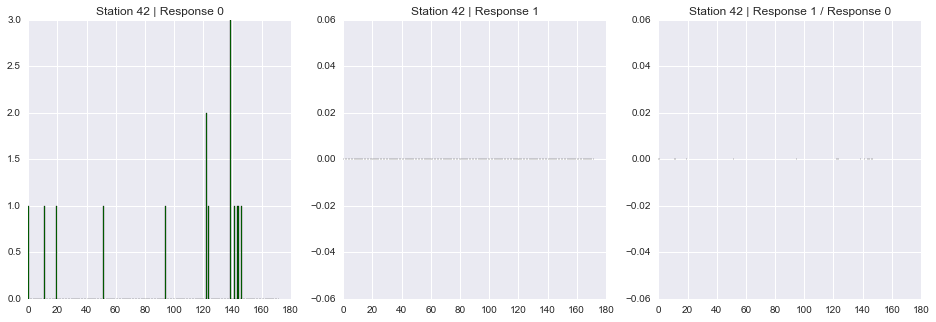

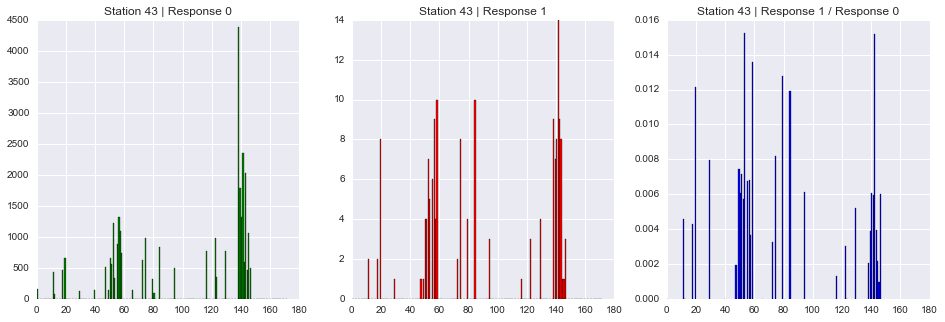

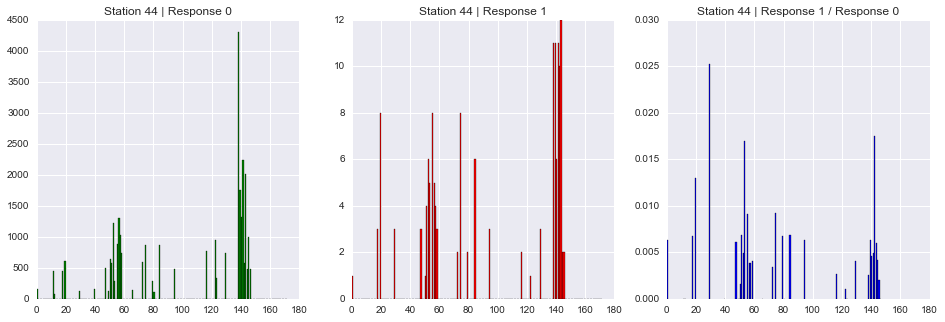

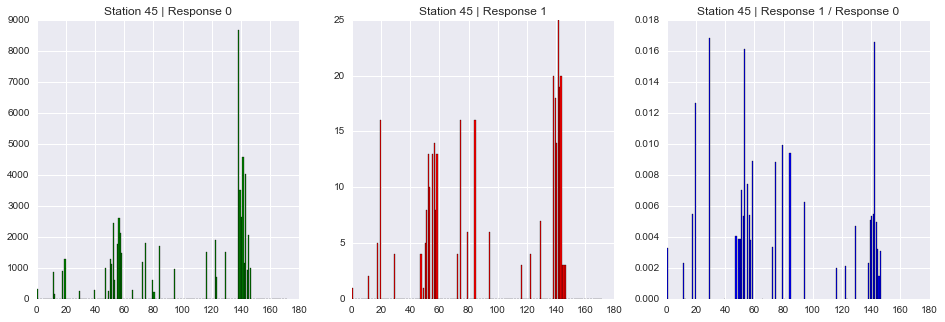

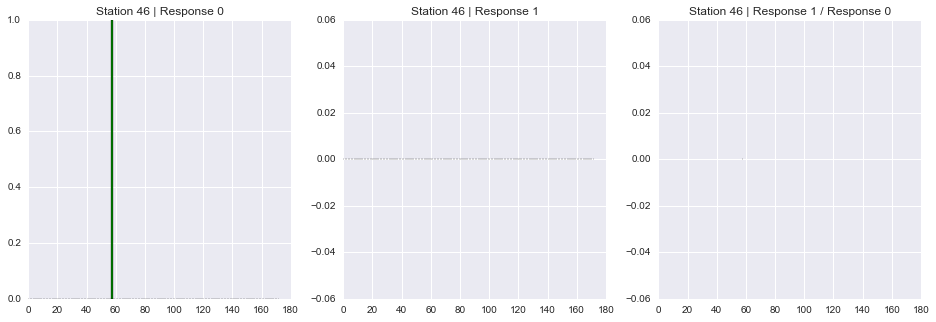

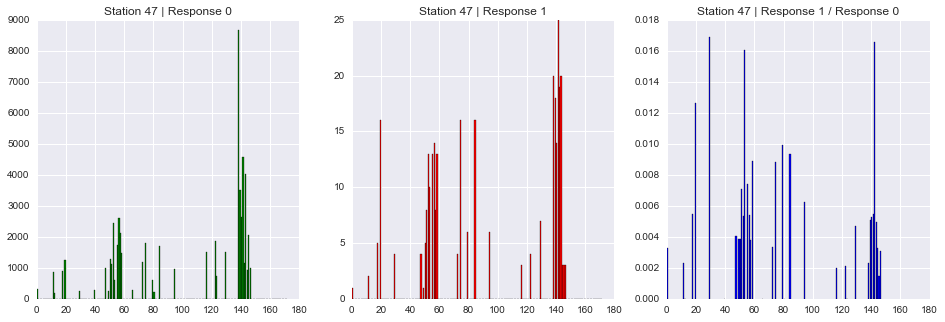

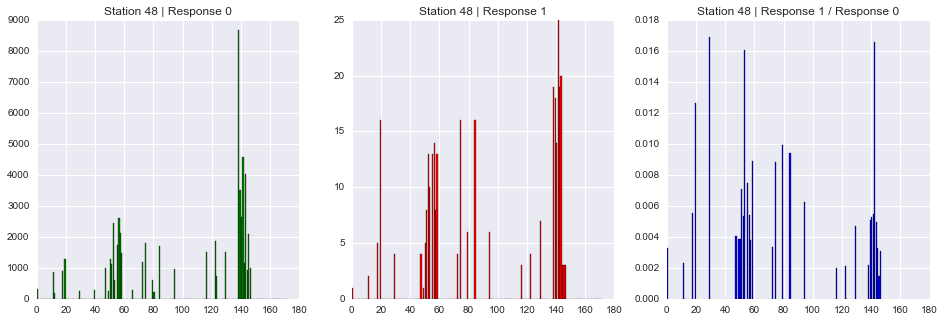

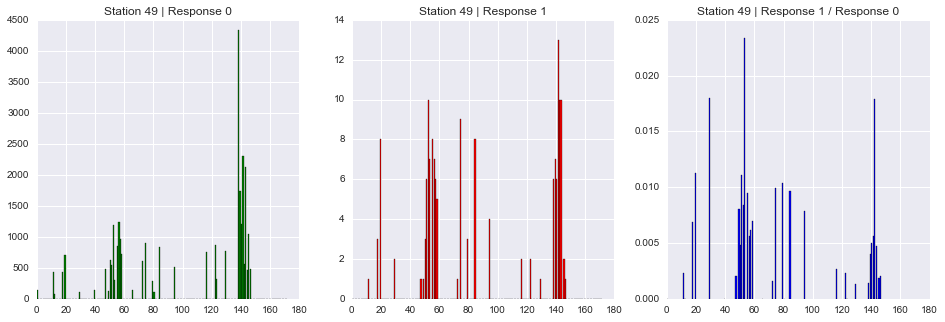

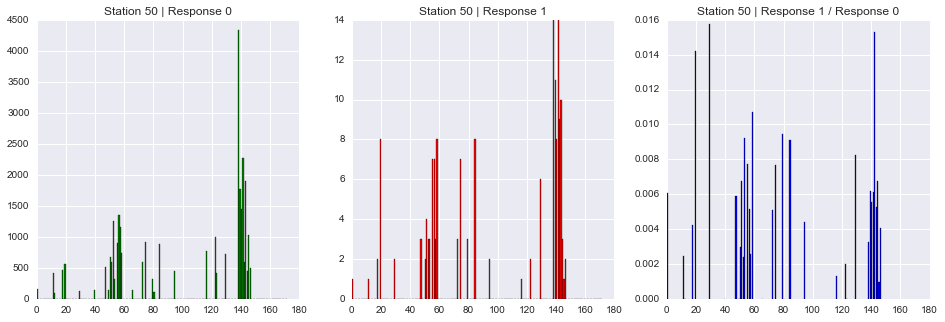

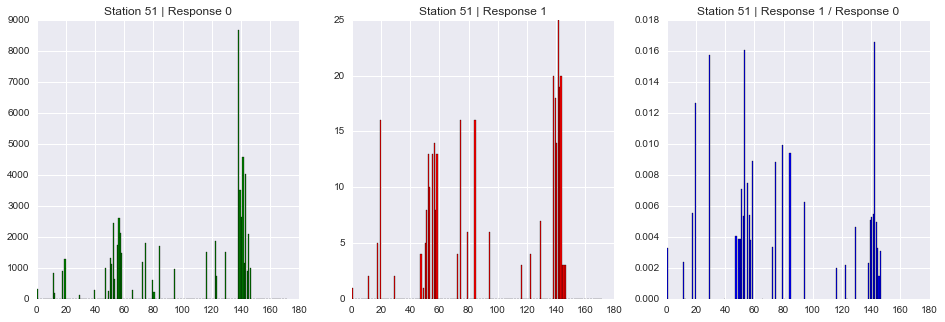

In [92]:
nbins = t_station_0.max().max()


for i in range(52):
    
    f_0, bins = np.histogram(t_station_0.iloc[i][~t_station_0.iloc[i].isnull()], bins=nbins, range=[0,nbins])
    f_1, bins = np.histogram(t_station_1.iloc[i][~t_station_1.iloc[i].isnull()], bins=nbins, range=[0,nbins])
    f_r = f_1.astype(float) / f_0
    
    if i==0:
        # Prepare dataframe to store all data
        df = pd.DataFrame(columns=[str(int(i)*time_window) for i in bins[1:]])
    
    bins = bins[:-1]
    
    df.loc[i] = f_r
    
    f,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,5), sharex=True)
    ax1.bar(bins, f_0, color='g')
    ax1.set_title('Station {} | Response 0'.format(i))
    ax2.bar(bins, f_1, color='r')
    ax2.set_title('Station {} | Response 1'.format(i))
    ax3.bar(bins, f_r, color='b')
    ax3.set_title('Station {} | Response 1 / Response 0'.format(i))

In [93]:
df[np.isinf(df)]=0

In [94]:
filename = 'eda_date_error_rate_matrix_tm_{}_V0'.format(time_window)

In [95]:
df.to_csv(os.path.join(const.DATA_PATH, filename + '.csv'), index_col='station_nr')

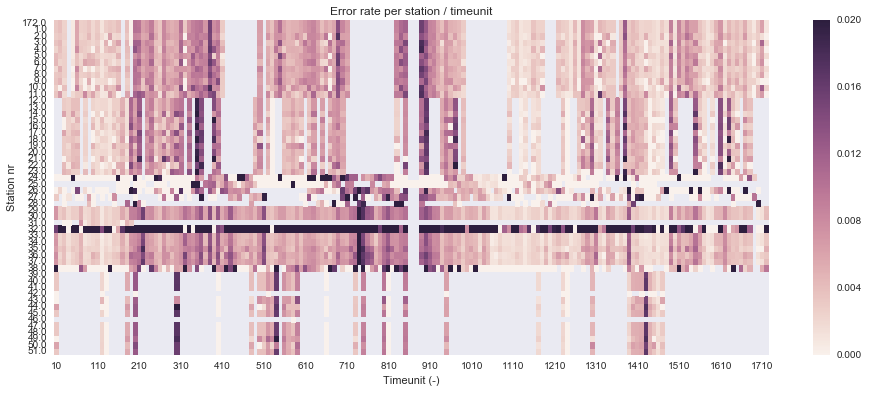

In [101]:
plt.figure(figsize=(16,6))
ax = sns.heatmap(df, vmax=0.02, xticklabels=10)
ax.set_ylabel('Station nr')
ax.set_xlabel('Timeunit (-)')
ax.set_title('Error rate per station / timeunit')
plt.savefig(os.path.join(const.DATA_PATH,  filename + '.png'.format(time_window)))

In [64]:
meta = {'script': 'eda_date.ipnb',
        'description': {'rows': 'station_number', 
                        'columns': 'max time of window',
                        'elements': 'samples with Response=0 / samples with Response=1 during this time window and this station'}
        }

func.write_meta_info(os.path.join(const.DATA_PATH, filename + '.log'), meta)